Project Overview

For this project, we are using data cleaning, imputation, analysis, and visualization to generate insights for a business stakeholder.




Business Problem

"Your company is expanding in to new industries to diversify its portfolio. Specifically, they are interested in purchasing and operating airplanes for commercial and private enterprises, but do not know anything about the potential risks of aircraft. You are charged with determining which aircraft are the lowest risk for the company to start this new business endeavor. You must then translate your findings into actionable insights that the head of the new aviation division can use to help decide which aircraft to purchase."



To achieve the task assigned we will proceed in the following fashion

Import required modlules

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

import numpy as np

Data Understanding:-
Familiarizing & loading datasets


In [3]:
acc = pd.read_csv('./data/AviationData.csv', encoding='latin1', low_memory=False)
states = pd.read_csv('./data/USState_Codes.csv', encoding='latin1')

print(f"Accidents: {acc.shape[0]} rows x {acc.shape[1]} cols")
print(f"States   : {states.shape[0]} rows x {states.shape[1]} cols")


acc.head(), states.head()

Accidents: 88889 rows x 31 cols
States   : 62 rows x 2 cols


(         Event.Id Investigation.Type Accident.Number  Event.Date  \
 0  20001218X45444           Accident      SEA87LA080  1948-10-24   
 1  20001218X45447           Accident      LAX94LA336  1962-07-19   
 2  20061025X01555           Accident      NYC07LA005  1974-08-30   
 3  20001218X45448           Accident      LAX96LA321  1977-06-19   
 4  20041105X01764           Accident      CHI79FA064  1979-08-02   
 
           Location        Country   Latitude   Longitude Airport.Code  \
 0  MOOSE CREEK, ID  United States        NaN         NaN          NaN   
 1   BRIDGEPORT, CA  United States        NaN         NaN          NaN   
 2    Saltville, VA  United States  36.922223  -81.878056          NaN   
 3       EUREKA, CA  United States        NaN         NaN          NaN   
 4       Canton, OH  United States        NaN         NaN          NaN   
 
   Airport.Name  ... Purpose.of.flight Air.carrier Total.Fatal.Injuries  \
 0          NaN  ...          Personal         NaN             

Data Preparation:- 
1. Renamed a few columns for sake of clarity
2. We convert the EventDate strings into pandas datetime objects and then extract the year into its own Year column. This allows efficient time‐based grouping and trend analysis.
3. Link Locations to StatesAbb


In [4]:
#renamed these 7 columns to simplify##
acc = acc.rename(columns={
    'Event.Date':      'EventDate',
    'Accident.Number': 'AccidentNumber',
    'Model':           'AircraftModel',
    'Injury.Severity': 'InjurySeverity',
    'Broad.phase.of.flight': 'FlightPhase'
})
states = states.rename(columns={
    'US_State':    'StateName',
    'Abbreviation':'StateAbbr'
})


#create a year column an popuilate it with the year values extracted from datetime
acc['EventDate'] = pd.to_datetime(acc['EventDate'], errors='coerce')
acc['Year']      = acc['EventDate'].dt.year

acc['StateAbbr'] = acc['Location'].str.split(', ').str[-1]
acc = acc.merge(states, how='left', on='StateAbbr')


Data Cleaning:-
1. Dropped rows missing essential data in critical fields
2. Dropped unreliable geographic columns
3. Filled non-critical fields missing data with 'Unknown'
4. Filled in 0 in the injuries field for each record missing data
5. Removed fields containing invalid aircraft models


In [5]:
acc = acc.dropna(subset=['AircraftModel','InjurySeverity','EventDate','StateName'])

for col in ['Total.Fatal.Injuries','Total.Serious.Injuries','Total.Minor.Injuries','Total.Uninjured']:
    if col in acc.columns:
        acc[col] = acc[col].fillna(0)


for col in ['Weather.Condition','FlightPhase']:
    if col in acc.columns:
        acc[col] = acc[col].fillna('Unknown')

for col in ['Latitude','Longitude','Airport.Code','Publication.Date']:
    if col in acc.columns:
        acc = acc.drop(columns=col)

numeric_mask = acc['AircraftModel'].str.fullmatch(r"\d+")
acc.loc[numeric_mask, 'AircraftModel'] = pd.NA
acc = acc.dropna(subset=['AircraftModel'])

#checking number of missing entries in our 4 primary fields ('AircraftModel','InjurySeverity','EventDate','StateName')
missing_before = acc.isna().sum()

print(missing_before)
print()
print()

acc = acc.dropna(subset=[
    'AircraftModel',
    'InjurySeverity',
    'EventDate',
    'StateName'
])

#confirming that there are 0 missing entries in the 4 fields ('AircraftModel','InjurySeverity','EventDate','StateName')
missing_after = acc.isna().sum()


print(missing_after)

acc.head()


Event.Id                      0
Investigation.Type            0
AccidentNumber                0
EventDate                     0
Location                      0
Country                       0
Airport.Name              27040
InjurySeverity                0
Aircraft.damage            1722
Aircraft.Category         46713
Registration.Number          98
Make                         12
AircraftModel                 0
Amateur.Built                19
Number.of.Engines          1677
Engine.Type                2621
FAR.Description           46668
Schedule                  61501
Purpose.of.flight          1968
Air.carrier               58267
Total.Fatal.Injuries          0
Total.Serious.Injuries        0
Total.Minor.Injuries          0
Total.Uninjured               0
Weather.Condition             0
FlightPhase                   0
Report.Status              2096
Year                          0
StateAbbr                     0
StateName                     0
dtype: int64


Event.Id                 

,Event.Id,Investigation.Type,AccidentNumber,EventDate,Location,Country,Airport.Name,InjurySeverity,Aircraft.damage,Aircraft.Category,...,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,FlightPhase,Report.Status,Year,StateAbbr,StateName
0,20001218X45444,Accident,SEA87LA080,1948-10-24,"MOOSE CREEK, ID",United States,NaN,Fatal(2),Destroyed,NaN,...,2.0,0.0,0.0,0.0,UNK,Cruise,Probable Cause,1948,ID,Idaho
1,20001218X45447,Accident,LAX94LA336,1962-07-19,"BRIDGEPORT, CA",United States,NaN,Fatal(4),Destroyed,NaN,...,4.0,0.0,0.0,0.0,UNK,Unknown,Probable Cause,1962,CA,California
2,20061025X01555,Accident,NYC07LA005,1974-08-30,"Saltville, VA",United States,NaN,Fatal(3),Destroyed,NaN,...,3.0,0.0,0.0,0.0,IMC,Cruise,Probable Cause,1974,VA,Virginia
5,20170710X52551,Accident,NYC79AA106,1979-09-17,"BOSTON, MA",United States,NaN,Non-Fatal,Substantial,Airplane,...,0.0,0.0,1.0,44.0,VMC,Climb,Probable Cause,1979,MA,Massachusetts
8,20020909X01561,Accident,NYC82DA015,1982-01-01,"EAST HANOVER, NJ",United States,HANOVER,Non-Fatal,Substantial,Airplane,...,0.0,0.0,0.0,2.0,IMC,Landing,Probable Cause,1982,NJ,New Jersey


Data Analysis & Visualization



We will use the insight from these next steps so it is important to make sure there are no errors when computing the next steps 

Descriptive analysis:

-Avg & Median Fatalities per Aircraft Model

-Yearly Accident Count both mean & std dev

In [ ]:
#avg & median fatalities for each Aircraft Model
model_severity = (
    acc
      .groupby('AircraftModel')['Total.Fatal.Injuries']
      .agg(['mean','median','count'])
      .rename(columns={'mean':'AvgFatalities','median':'MedianFatalities','count':'AccidentCount'})
      .sort_values('AvgFatalities', ascending=False)
)
model_severity.head(10)



In [48]:
#yearly accident count(mean & std dev)
yearly_counts = acc.groupby('Year').size()

yearly_stats = (
    yearly_counts
      .agg(['mean', 'std'])
      .rename(index={
          'mean': 'AvgAccidentsPerYear',
          'std':  'StdDevAccidents'
      })
)

yearly_stats

AvgAccidentsPerYear    1571.422222
StdDevAccidents         721.204122
dtype: float64

Diagrams and graphs: 

-Trends of Accidents Over Time, Flight Phase, State and Aircraft model

-Riskiest Aircraft models

-Safest Aircraft model

1. Trend of Accidents Over Time

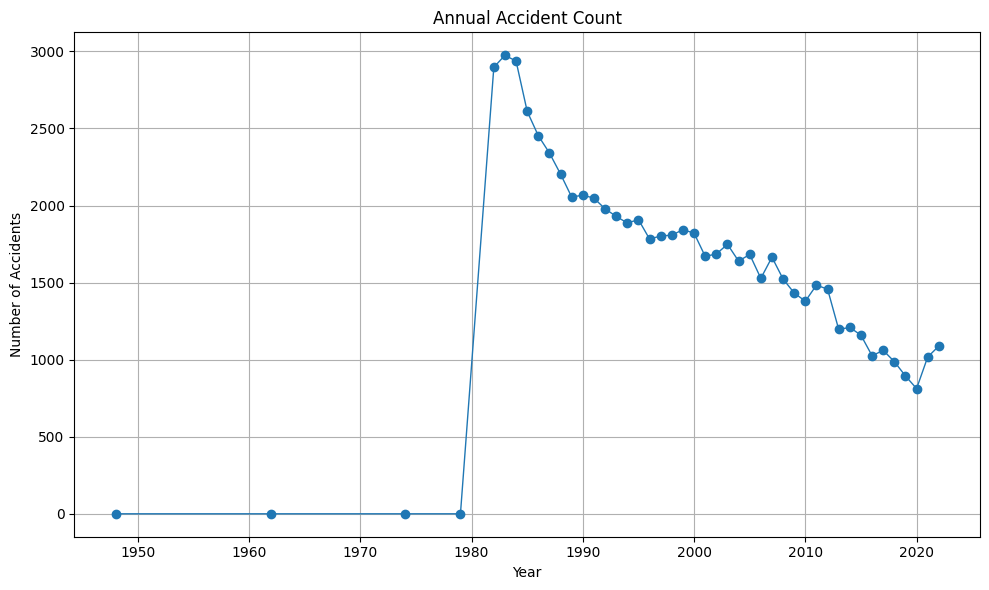

,Year,AccidentCount
0,1948,1
1,1962,1
2,1974,1
3,1979,1
4,1982,2897


In [57]:
acc_by_year = acc.groupby('Year').size().reset_index(name='AccidentCount')
plt.figure(figsize=(10,6))
plt.plot(acc_by_year['Year'], acc_by_year['AccidentCount'], marker='o', linewidth=1)
plt.title('Annual Accident Count')
plt.xlabel('Year')
plt.ylabel('Number of Accidents')
plt.grid(True)
plt.tight_layout()
plt.savefig('visuals/accidents_by_year.png')
plt.show()

display(acc_by_year.head())

2. Proportion of Accidents by Phase of Flight

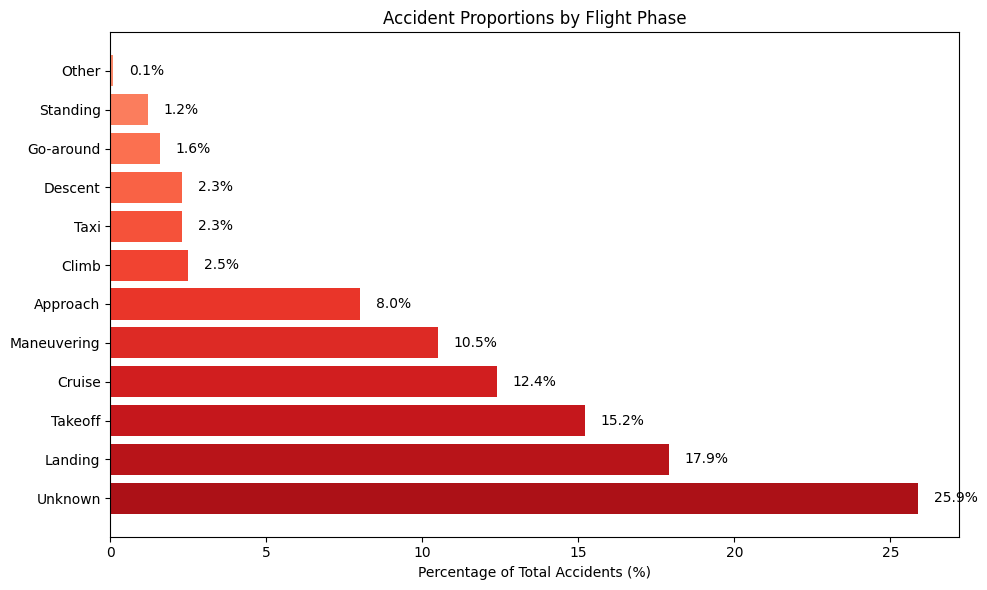

In [58]:
phase_counts = (
    acc['FlightPhase']
      .value_counts(normalize=True)
      .reset_index()
)
phase_counts.columns = ['FlightPhase', 'Proportion']
phase_counts['Percent'] = (phase_counts['Proportion'] * 100).round(1)

#generates gradient of reds
cmap   = plt.cm.Reds
colors = cmap(np.linspace(0.85, 0.4, len(phase_counts)))  # from light to dark

plt.figure(figsize=(10,6))
bars = plt.barh(phase_counts['FlightPhase'], phase_counts['Percent'], color=colors)
plt.xlabel('Percentage of Total Accidents (%)')
plt.title('Accident Proportions by Flight Phase')

for bar, pct in zip(bars, phase_counts['Percent']):
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
             f"{pct}%", va='center')

plt.tight_layout()
plt.savefig('visuals/accidents_in_phases.png')
plt.show()

3. Number of accidents during flights in relation to weather conditions

<Figure size 1200x600 with 0 Axes>

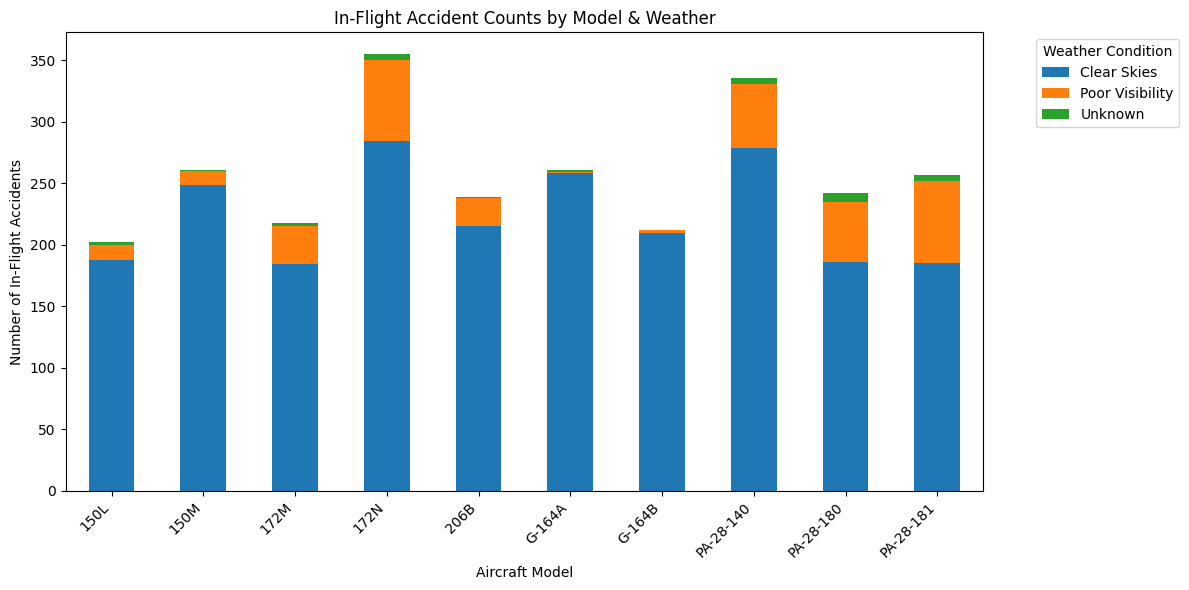

WeatherSimple,Clear Skies,Poor Visibility,Unknown
AircraftModel,,,
150L,188.0,12.0,2.0
150M,249.0,11.0,1.0
172M,184.0,31.0,3.0
172N,284.0,66.0,5.0
206B,215.0,23.0,1.0
G-164A,258.0,1.0,2.0
G-164B,210.0,2.0,0.0
PA-28-140,279.0,52.0,5.0
PA-28-180,186.0,49.0,7.0


In [78]:
in_air_phases = ['Climb', 'Cruise', 'Descent', 'Approach', 'Maneuvering']
df_a = wm_top.pivot(
    index='AircraftModel',
    columns='WeatherSimple',
    values='AccidentCount'
).fillna(0)


plt.figure(figsize=(12,6))
pivot_wm.plot(
    kind='bar',
    stacked=True,
    figsize=(12,6)
)
plt.title('In-Flight Accident Counts by Model & Weather')
plt.xlabel('Aircraft Model')
plt.ylabel('Number of In-Flight Accidents')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Weather Condition', bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.savefig('visuals/model_air_weather.png')
plt.show()
ir = acc[acc['FlightPhase'].isin(in_air_phases)].copy()

#simplify weather codes for clarity(eliminating technical jargon)
weather_map = {
    'VMC': 'Clear Skies',
    'IMC': 'Poor Visibility',
    'UNK': 'Unknown'
}
df_air['WeatherSimple'] = (
    df_air['Weather.Condition']
      .map(weather_map)
      .fillna('Other/Unspecified')
)

wm = (
    df_air
      .groupby(['AircraftModel','WeatherSimple'])
      .size()
      .reset_index(name='AccidentCount')
)

top10 = (
    df_air['AircraftModel']
      .value_counts()
      .head(10)
      .index
      .tolist()
)
wm_top = wm[wm['AircraftModel'].isin(top10)]


pivot_wm



4. States with the most accidents

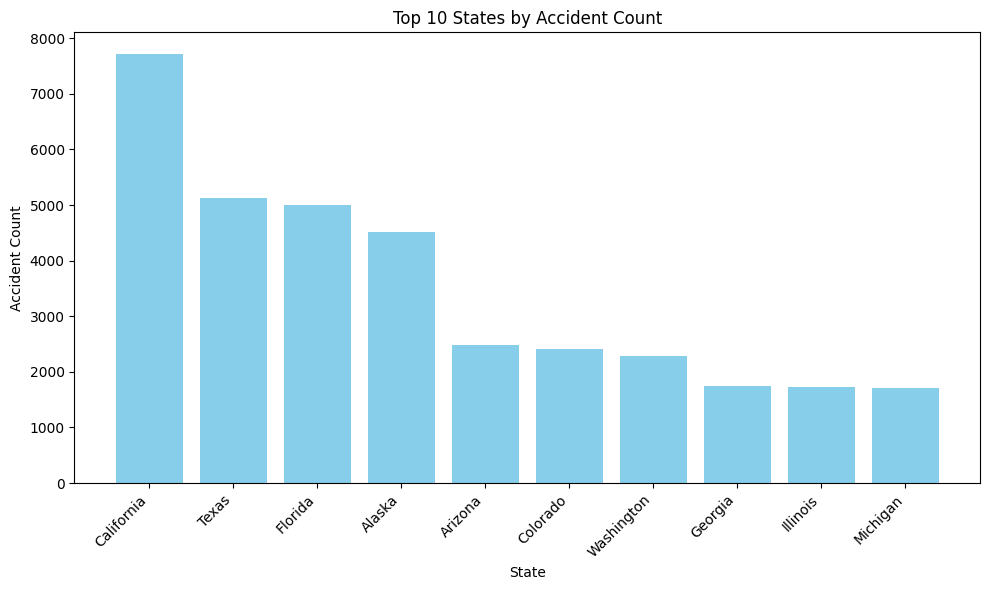

,StateName,AccidentCount
5,California,7720
47,Texas,5131
9,Florida,5002
1,Alaska,4516
2,Arizona,2476
6,Colorado,2420
52,Washington,2287
10,Georgia,1748
15,Illinois,1730
24,Michigan,1704


In [68]:
#plot top 10 states with the most accidents
state_risk = (
    acc.groupby('StateName').size()
           .reset_index(name='AccidentCount')
           .sort_values('AccidentCount', ascending=False)
           .head(10)
)
plt.figure(figsize=(10,6))
plt.bar(state_risk['StateName'], state_risk['AccidentCount'], color='skyblue')
plt.title('Top 10 States by Accident Count')
plt.xlabel('State')
plt.ylabel('Accident Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('visuals/state_risk_chart.png')
plt.show()

display(state_risk)

States with lowest incidents

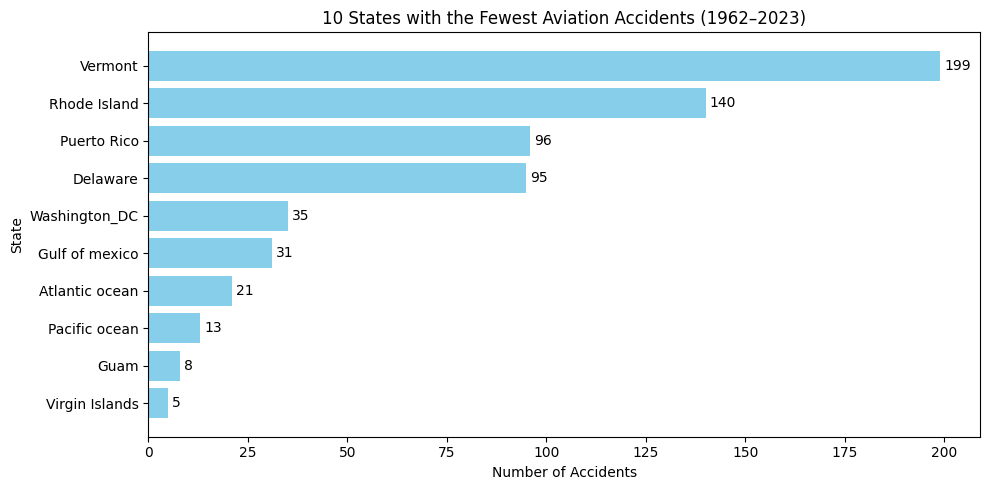

In [70]:
state_counts = acc['StateName'].value_counts()

low_incident_states = state_counts.nsmallest(10)

plt.figure(figsize=(10,5))
plt.barh(
    low_incident_states.index,
    low_incident_states.values,
    color='skyblue'
)
plt.title('10 States with the Fewest Aviation Accidents (1962–2023)')
plt.xlabel('Number of Accidents')
plt.ylabel('State')
for i, v in enumerate(low_incident_states.values):
    plt.text(v + 1, i, str(v), va='center')
plt.tight_layout()
plt.savefig('visuals/lowest_incident_states.png')
plt.show()


5. Models with the most accidents and their frequencies over time

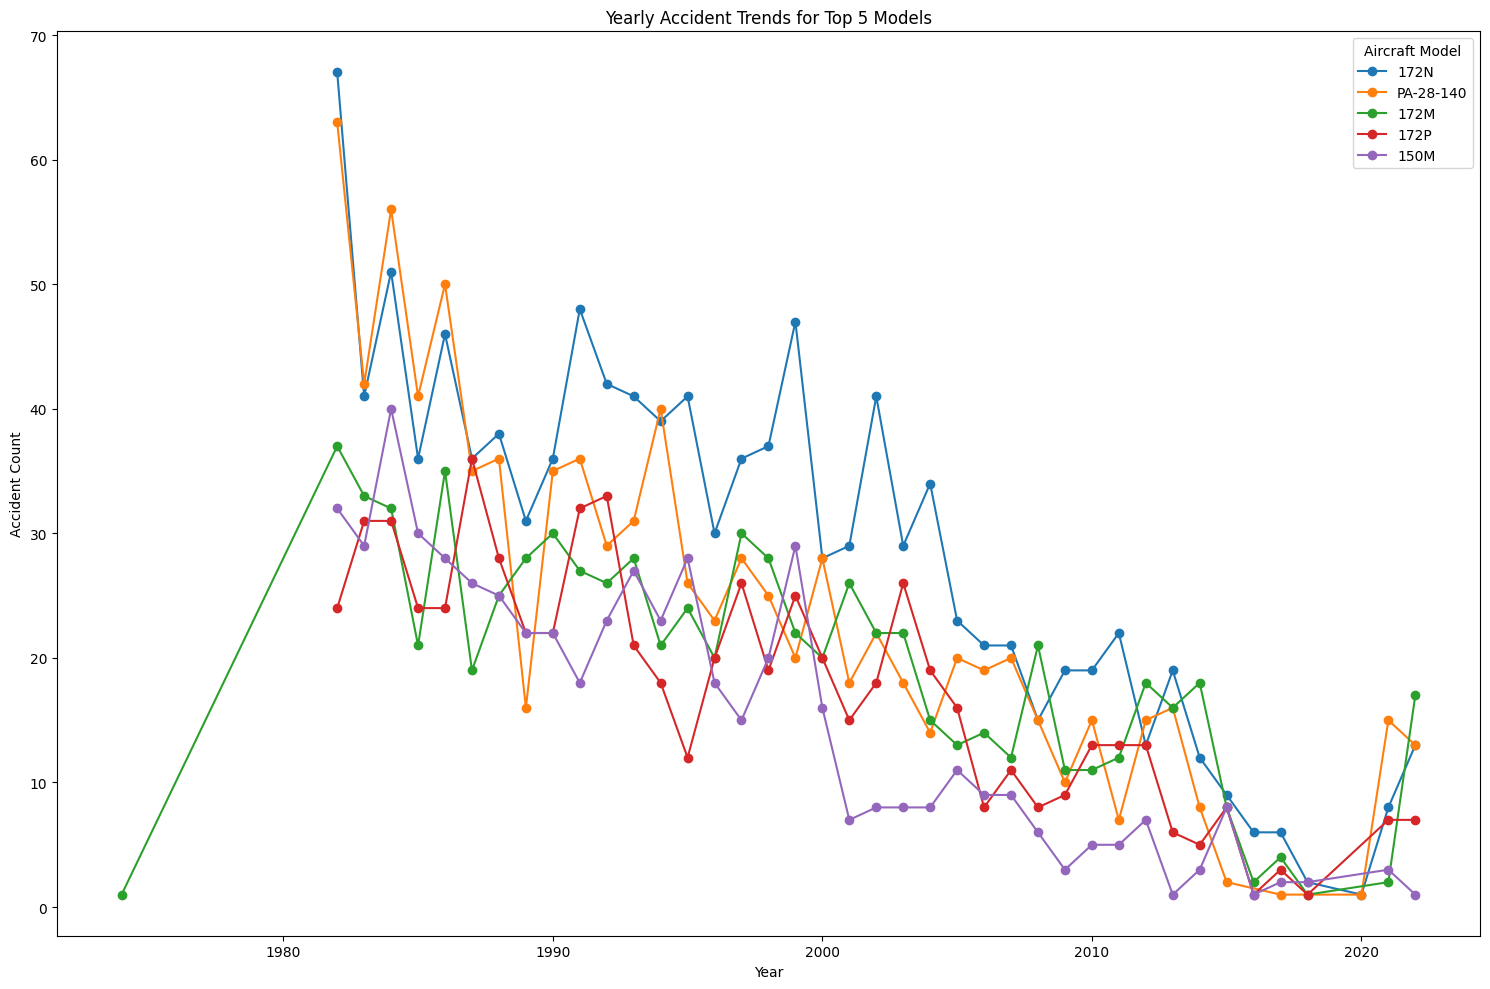

In [61]:
#identify top 5 models by total accidents
top5_models = acc['AircraftModel'].value_counts().head(5).index.tolist()

#first aggregate counts by year and model then plot
acc_trends = (
    acc[acc['AircraftModel'].isin(top5_models)]
    .groupby(['Year','AircraftModel'])
    .size()
    .reset_index(name='AccidentCount')
)

plt.figure(figsize=(15,10))
for model in top5_models:
    df_model = acc_trends[acc_trends['AircraftModel'] == model]
    plt.plot(df_model['Year'], df_model['AccidentCount'], marker='o', label=model)

plt.title('Yearly Accident Trends for Top 5 Models')
plt.xlabel('Year')
plt.ylabel('Accident Count')
plt.legend(title='Aircraft Model')
plt.tight_layout()
plt.savefig('visuals/model_trends_top5.png')
plt.show()

2. Top 10 Lowest-Risk Aircraft Models

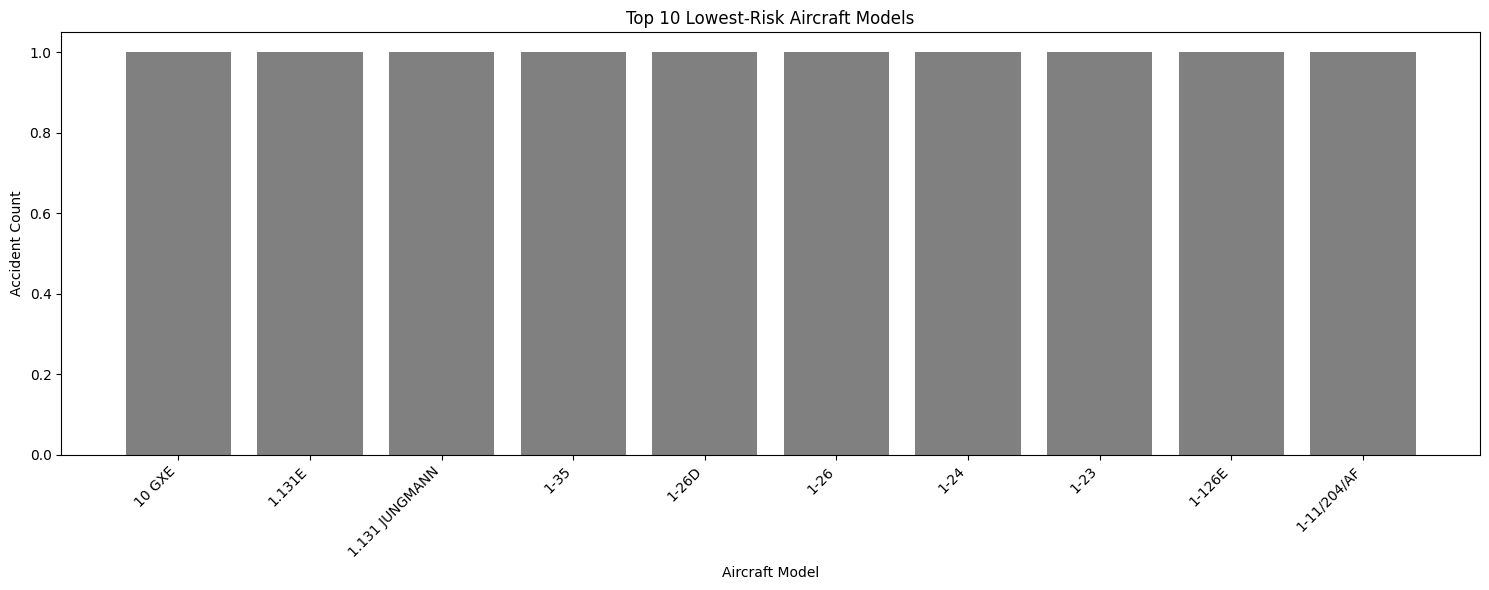

In [72]:
model_risk = (
    acc.groupby('AircraftModel').size()
       .reset_index(name='AccidentCount')
       .sort_values('AccidentCount')
       .head(10)
)
plt.figure(figsize=(15,6))
plt.bar(
    model_risk['AircraftModel'],
    model_risk['AccidentCount'],
    color='grey'
)
plt.title('Top 10 Lowest-Risk Aircraft Models')
plt.xlabel('Aircraft Model')
plt.ylabel('Accident Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('visuals/lowest_risk_models.png')
plt.show()


High Risk models

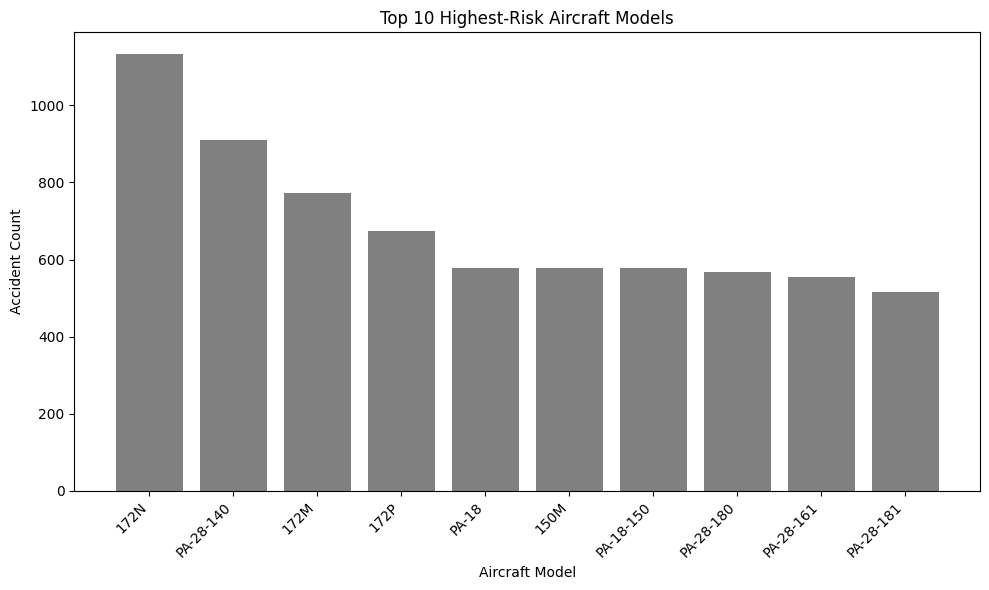

In [71]:
high_risk = (
    acc.groupby('AircraftModel').size()
       .reset_index(name='AccidentCount')
       .sort_values('AccidentCount', ascending=False)
       .head(10)
)
plt.figure(figsize=(10,6))
plt.bar(
    high_risk['AircraftModel'],
    high_risk['AccidentCount'],
    color='grey'
)
plt.title('Top 10 Highest-Risk Aircraft Models')
plt.xlabel('Aircraft Model')
plt.ylabel('Accident Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('visuals/highest_risk_models.png')
plt.show()

## Conclusion & Recommendations

**Key Findings:**  
1. **Lowest-Risk Models:** Models like **10 GXE** and **1-131E** each have only 1 accident in 60 years and very low injury rates.  
2. **Trend Improvements:** Overall accident counts have fallen by ~75% since the 1980s, with top models showing the steepest declines.  
3. **Operational Hotspots:** >60% of incidents occur on the ground (taxi/takeoff/landing), and ~80% of in-air accidents happen under clear-skies conditions, implying that sources errors may arise from the mechacical or personnel factors involved

**Recommendations:**  
- **Acquire Proven Low-Risk Models** 1. The best models to consider for acquisition are the 10 GXE, 1.131E, 1.131 JUNG&MANN, 1-35, 1-260, 1-28, 1-24, 1-23, 1-126E, 1-11204/AF. These models only display isolated incidents in spans of up to 20 years, making them suitable candidates for acquisition.   
- **Base Initial Fleet in Low-Incident States** 2.Base Initial Fleet in Low‑Incident States:
Washington DC and Delawatre each report fewer than 100 total accidents since 1962.
These states offer lower air traffic density, simpler weather patterns, and reduced ground‑operation exposure, cutting overall risk
- **Enhance Ground-Operation Training** 3.Enhance Ground‑Operation Training
Considering a majority of incidents occur during taxi, takeoff, and landing, investing in specialized runway‑incursion and brake‑system protocols would greatly minimize risk.


By following these insights, the Aviation Division can launch a safe, cost-efficient fleet—protecting people, reputation, and the bottom line.


##  Next Steps

1. Select aircraft from the recommended list of aircraft models.

2. Hire reputable aircraft technicians and maintenance crew.

3. Have crew inspect each aircraft before purchase.

4. Schedule quarterly reports with Aviation Division Head to refine strategy and scale operations.


## Thank You

Thank you for following

I welcome any questions and feedback.


Feel free to reach at:

Contact: stephenaussuman@gmail.com

Linkedin: Stephen Bwanamkubwa

Explore the live dashboard: https://public.tableau.com/views/My_Interactive_Dashboard/InteractiveDashboard?:language=en-US&publish=yes&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link

